# Modern Variational Inference

In this tutorial, we'll analyze images of stars using modern variational inference and PyTorch. First let's import some packages that we'll use throughout.

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions import Pareto, Poisson, Normal

_ = torch.manual_seed(0)

## Generating the data
For simplicity, and so that we can know the ground truth, we'll use synthetic data. Let's generate it. The next block of code defines a pixelated point spread function (PSF).

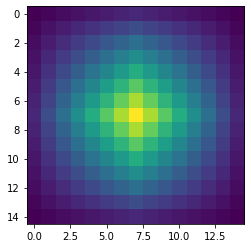

In [2]:
n = 16  # the number of images in our dataset
img_dim = 15  # the height and width of our images. must be odd

psf_marginal = 1 + torch.arange(img_dim, dtype=torch.float32)
half_dim = img_dim // 2
psf_marginal[half_dim:] -= 2 * torch.arange(half_dim + 1)
psf = torch.mm(psf_marginal.view(img_dim, 1), psf_marginal.view(1, img_dim))
psf /= psf.sum()

_ = plt.imshow(psf.data)

In our generative model, the flux for each star follows a Gaussian distribution:

In [3]:
min_flux = 100 / psf.max()
flux_prior = Normal(10 * min_flux, 2 * min_flux)

To generate our synthetic dataset, let's draw the "true" fluxes of `n` stars. These are the latent values we'll subsequently aim to infer.

In [4]:
true_fluxes = flux_prior.sample([n])
print(f"flux mean: {true_fluxes.mean().item()}")
print(f"flux sd: {true_fluxes.std().item()}")
print(f"flux min: {true_fluxes.min().item()}")
print(f"flux max: {true_fluxes.max().item()}")

flux mean: 62472.703125
flux sd: 11990.9462890625
flux min: 36925.1875
flux max: 79842.0234375


In a realistic model of images of stars, a fixed background intensity is added to flux-scaled PSF to give the expected intensity of each pixel:

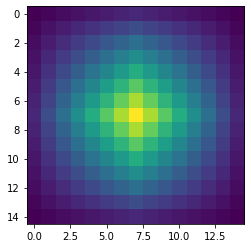

In [5]:
background_intensity = 3 * min_flux
star_intensity = true_fluxes.view(n, 1, 1) * psf.view(1, img_dim, img_dim)
true_intensity = background_intensity + star_intensity
_ = plt.imshow(true_intensity[0])

Now let's draw some images of stars with the fluxes we've previously sampled:

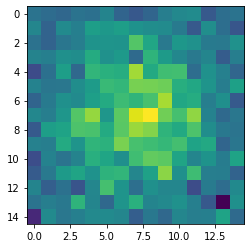

In [6]:
images = Poisson(true_intensity).sample()
_ = plt.imshow(images[0])

## Numerical integration

Numerical integration is a precursor to varational inference.
Numerical integration approximates integrals by partitioning the domain into a grid, evaluating the integrand at each point of the grid, and averaging these values.
In Bayesian inference, the integrand is the joint distribution: $$p(\mathrm{fluxes}, \mathrm{images}) = p(\mathrm{fluxes}) \, p(\mathrm{images} \mid \mathrm{fluxes}).$$
Integrating out the fluxes gives us $p(\mathrm{images}).$
Then, using Bayes rule, we can solve for the posterior, i.e.,
$$p(\mathrm{fluxes} \mid \mathrm{images}) = \frac{p(\mathrm{images} \mid \mathrm{fluxes}) \, p(\mathrm{fluxes})}{p(\mathrm{images})}.$$

In [7]:
bin_width = 100
grid_size = 5000
flux_grid = min_flux + torch.arange(grid_size) * bin_width

rate = psf.view(1, img_dim, img_dim, 1) * flux_grid.view(1, 1, 1, grid_size)
rate += background_intensity

# conditional log likelihood (for each observed image and each flux grid point)
images4d = images.view(n, img_dim, img_dim, 1)
log_p_images_given_fluxes = Poisson(rate).log_prob(images4d).sum([1, 2])
assert log_p_images_given_fluxes.shape == (n, grid_size)

# joint log likelihood
log_p_fluxes_and_images = log_p_images_given_fluxes + flux_prior.log_prob(flux_grid)
assert log_p_fluxes_and_images.shape == (n, grid_size)

# posterior log likelihood
log_p_fluxes_given_images = min_flux + log_p_fluxes_and_images * bin_width
assert log_p_fluxes_given_images.shape == (n, grid_size)

Comparing point estimates to the ground truth is one way to assess how well various inference methods a performing.

In [8]:
def flux_rmse(est_fluxes):
    return (true_fluxes - est_fluxes).pow(2).mean().sqrt()

print(f"prior mean RMSE: {flux_rmse(flux_prior.mean)}")

ss_flux = (images - background_intensity).sum([1,2])
print(f"sky subtracted RMSE: {flux_rmse(ss_flux)}")

mle_flux = min_flux + 1 + log_p_images_given_fluxes.argmax(1) * bin_width
print(f"grid MLE RMSE: {flux_rmse(mle_flux)}")

map_flux = min_flux + 1 + log_p_fluxes_and_images.argmax(1) * bin_width
print(f"grid MAP RMSE: {flux_rmse(map_flux)}")

# This formula can be deleted for students to fill in.
# The markdown above would need to give them more guidance on how to do it.
posterior_mean = (log_p_fluxes_given_images.softmax(1) * flux_grid.view(1, grid_size)).sum(1)
print(f"grid posterior mean RMSE: {flux_rmse(posterior_mean)}")

prior mean RMSE: 11710.2080078125
sky subtracted RMSE: 1745.073486328125
grid MLE RMSE: 1218.2911376953125
grid MAP RMSE: 1201.5496826171875
grid posterior mean RMSE: 1196.5240478515625


## Variational inference
In variational inference, we attempt to find a distribution $q(\mathrm{flux})$ that minimizes $$\mathrm{KL}(q(\mathrm{flux})\, \| \, p(\mathrm{flux} \mid \mathrm{images}).$$
Below, we restrict $q$ to the the class of $n$-dimensional multivariate normal distributions that have a diagonal covariance matrix.
The approximation $q$ is parameterized by a unique mean and standardization for each images.
We compute stochastic gradients of the objective function using the reparameterization trick, and use stochastic gradient descent for optimization.

In [9]:
q_mean = nn.Parameter((images - background_intensity).sum([1,2]) + 5000)
q_sd = nn.Parameter(torch.ones(n) * 100)

optimizer = torch.optim.SGD([q_mean, q_sd], lr=100)
num_samples = 64  # number of samples of q per image

for i in range(3000):
    q = Normal(q_mean, q_sd.clamp(1e-4))
    z = q.rsample((num_samples,))
    zt = z.permute(1, 0)

    rate = psf.view(1, img_dim, img_dim, 1) * zt.view(n, 1, 1, num_samples)
    rate += background_intensity
    cond_ll = Poisson(rate)
    
    # This formula can be deleted for students to fill in.
    # The markdown above would need to give them more guidance on how to do it.
    neg_elbo = q.log_prob(z).sum()
    neg_elbo -= flux_prior.log_prob(z).sum()
    neg_elbo -= cond_ll.log_prob(images.view(n, img_dim, img_dim, 1)).sum()
    
    if i % 200 == 0:
        obj = neg_elbo.item() / num_samples
        rmse = flux_rmse(q_mean)
        print(f"[{i}] objective: {obj}   rmse: {rmse}")
    
    optimizer.zero_grad()
    neg_elbo.sum().backward()
    optimizer.step()

[0] objective: 23065.56640625   rmse: 5126.71337890625
[200] objective: 22985.771484375   rmse: 3339.947998046875
[400] objective: 22966.779296875   rmse: 2279.43408203125
[600] objective: 22959.607421875   rmse: 1691.5357666015625
[800] objective: 22956.845703125   rmse: 1393.9405517578125
[1000] objective: 22955.919921875   rmse: 1261.25
[1200] objective: 22955.5703125   rmse: 1207.4072265625
[1400] objective: 22955.103515625   rmse: 1187.6197509765625
[1600] objective: 22954.8203125   rmse: 1181.0772705078125
[1800] objective: 22955.30078125   rmse: 1177.0340576171875
[2000] objective: 22955.255859375   rmse: 1175.362548828125
[2200] objective: 22955.1640625   rmse: 1177.213623046875
[2400] objective: 22954.951171875   rmse: 1176.0648193359375
[2600] objective: 22954.919921875   rmse: 1177.2445068359375
[2800] objective: 22955.115234375   rmse: 1177.30615234375


The approach above can be slow because it requires us to effectively solve a unique optimization problem for each image. Amortized inference is more efficient for large datasets. In amortized inference, the approximating distribution for each of the $n$ images is specified by shared neural network, called an encoder. 

In [10]:
class StarEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim * img_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )
    
    def forward(self, x):
        x = x.view(-1, img_dim ** 2)
        out = self.net(x)
        q_mean = out[:, 0]
        q_sd = out[:, 1].clamp(-6, 6).exp()
        return Normal(q_mean, q_sd)
    

encoder = StarEncoder()
optimizer = torch.optim.SGD(encoder.parameters(), lr=1e-3)

mb = 8   # minibatch size
num_samples = 64  # number of samples of q per image in the minibatch

for i in range(30000):
    indices = torch.randint(n, (mb,))
    x = images[indices]

    q = encoder(x)

    z = q.rsample((num_samples,))
    zt = z.permute(1, 0)
    
    rate = psf.view(1, img_dim, img_dim, 1) * zt.view(mb, 1, 1, num_samples)
    rate = rate.clamp(0) + background_intensity
    cond_ll = Poisson(rate)

    # This formula can be deleted for students to fill in.
    # The markdown above would need to give them more guidance on how to do it.
    neg_elbo = q.log_prob(z).sum()
    neg_elbo -= flux_prior.log_prob(z).sum()
    neg_elbo -= cond_ll.log_prob(x.view(mb, img_dim, img_dim, 1)).sum()

    if i % 500 == 0:
        obj = neg_elbo.item() * n / (mb * num_samples)
        rmse = flux_rmse(encoder(images).mean)
        print(f"[{i}] objective: {obj}   rmse: {rmse}")

    optimizer.zero_grad()
    neg_elbo.sum().backward()
    optimizer.step()

[0] objective: 36071.2578125   rmse: 63542.5625
[500] objective: 31334.5703125   rmse: 51528.421875
[1000] objective: 22953.80078125   rmse: 1900.31103515625
[1500] objective: 22950.99609375   rmse: 1464.3970947265625
[2000] objective: 23191.30078125   rmse: 1427.53759765625
[2500] objective: 23107.876953125   rmse: 1913.392578125
[3000] objective: 23004.4609375   rmse: 2186.76171875
[3500] objective: 23228.142578125   rmse: 1484.990966796875
[4000] objective: 22941.87109375   rmse: 1512.164306640625
[4500] objective: 22998.06640625   rmse: 1491.73779296875
[5000] objective: 22960.20703125   rmse: 1480.7032470703125
[5500] objective: 22996.619140625   rmse: 1628.3642578125
[6000] objective: 22989.451171875   rmse: 1435.3909912109375
[6500] objective: 22993.921875   rmse: 1261.2591552734375
[7000] objective: 23001.00390625   rmse: 1286.1400146484375
[7500] objective: 22980.779296875   rmse: 1470.15185546875
[8000] objective: 23127.2421875   rmse: 1772.8072509765625
[8500] objective: 230